# Import Libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


# Obtain Data

In [2]:
df = pd.read_csv('../Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [4]:
df.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Name', 'Age', 'Fare'], inplace=True)
df.head()

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S


Create dummy columns for Pclass and Sex categorical variables

In [5]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first=False)
df.drop(columns=['Pclass_2', 'Sex_female'], inplace=True)
df.head()

,Survived,Embarked,Pclass_1,Pclass_3,Sex_male
0,0,S,0,1,1
1,1,C,1,0,0
2,1,S,0,1,0
3,1,S,1,0,0
4,0,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [6]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dummy_na=True)
df.drop(columns=['Embarked_Q'], inplace=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_S'] = np.nan
        row['Embarked_C'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,1.0


Impute missing age values with knn imputer

In [7]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived
0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,0.0


Confirm data now scrubbed with df.info()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass_1    891 non-null    float64
 1   Pclass_3    891 non-null    float64
 2   Sex_male    891 non-null    float64
 3   Embarked_C  891 non-null    float64
 4   Embarked_S  891 non-null    float64
 5   Survived    891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


# Explore Data

Find train set outliers with isolation forest

In [9]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Outlier
874,-0.5,-1.1,-1.4,2.1,-1.6,-1
303,-0.5,-1.1,-1.4,-0.5,-1.6,-1
389,-0.5,-1.1,-1.4,2.1,-1.6,-1
473,-0.5,-1.1,-1.4,2.1,-1.6,-1
608,-0.5,-1.1,-1.4,2.1,-1.6,-1
322,-0.5,-1.1,-1.4,-0.5,-1.6,-1


Find test set outliers with Isolation Forest

In [10]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Outlier
43,-0.5,-1.1,-1.4,2.1,-1.6,-1
866,-0.5,-1.1,-1.4,2.1,-1.6,-1
9,-0.5,-1.1,-1.4,2.1,-1.6,-1


Calculate descriptive statistics for each feature

In [11]:
df.describe().iloc[:, 0:10]

,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.242424,0.551066,0.647587,0.188552,0.725028,0.383838
std,0.428790,0.497665,0.477990,0.391372,0.446751,0.486592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

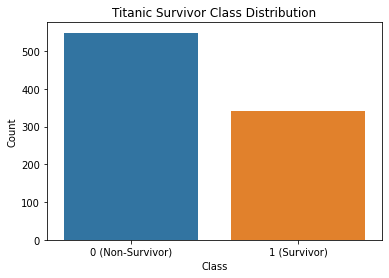

In [12]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

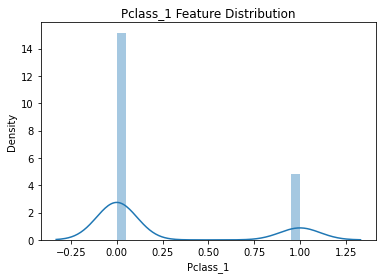

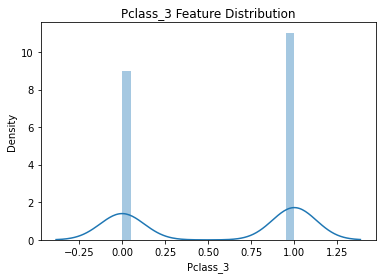

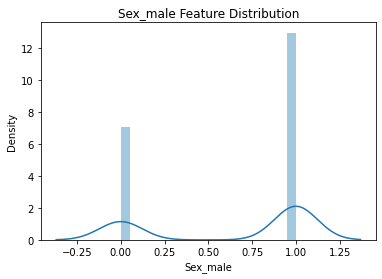

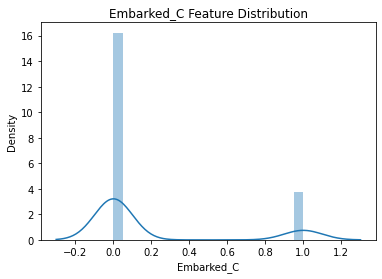

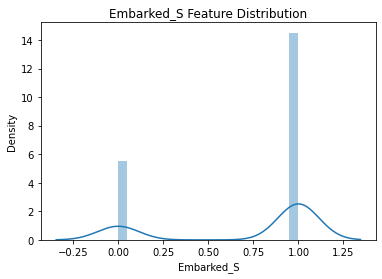

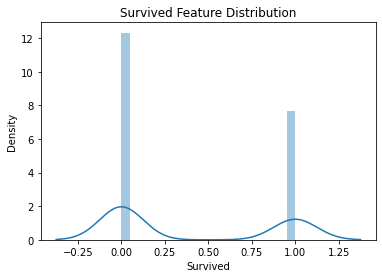

In [13]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [14]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,18.4
1,Embarked_C,2.8
2,Embarked_S,2.7
3,Pclass_1,1.8
4,Pclass_3,1.7
5,Sex_male,1.0


# Model Data

Create x and y variables

In [15]:
x = df.drop(columns=['Survived'])
y = df['Survived']

Perform train test split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [17]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [18]:
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.380952380952381
Train Accuracy Score: 0.5329341317365269
Test f1 Score:  0.426829268292683
Test Accuracy Score: 0.57847533632287


Gridsearch Logistic Regression Model

In [21]:
lr_gs_dict = {'C': [x/1000 for x in range(1, 101)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
LogisticRegression(C=0.013, random_state=204)
0.8099091011109865


Build and evaluate top performing gridsearch logistic regression model

In [25]:
lr = LogisticRegression(C=.013, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create logistic regression Confusion Matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

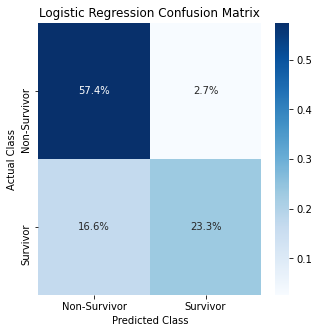

In [27]:
cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('Logistic Regression Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch SVC model

In [28]:
svc_gs_dict = {'C': [x/1000 for x in range(50, 101)],
               'gamma': [x/1000 for x in range(250, 301)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 2601 candidates, totalling 13005 fits
SVC(C=0.067, gamma=0.271, random_state=491)
0.8128941757378522


Fit and evaluate top performing SVC model

In [29]:
svc = SVC(C=.067, gamma=.271, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create SVC Confusion Matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

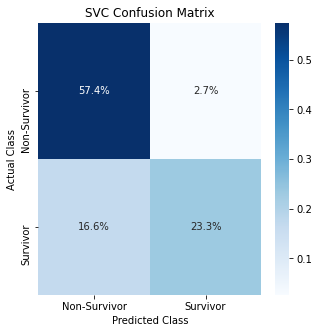

In [30]:
cm = confusion_matrix(y_test, y_test_pred_svc)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch adaboost model

In [37]:
ab_gs_dict = {'learning_rate': [x/10000 for x in range(0, 201)],
             'n_estimators': [x*10 for x in range(5, 11)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 1206 candidates, totalling 6030 fits
AdaBoostClassifier(learning_rate=0.0001, random_state=19)
0.7979126921782067


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.79791269 0.79791269 0.79791269]
  warnings.warn(


Fit and evaluate top performing adaboost model

In [38]:
ab = AdaBoostClassifier(learning_rate=.0001, n_estimators=50, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.7204968944099378
Train Accuracy Score: 0.7979041916167665
Test f1 Score:  0.6820809248554913
Test Accuracy Score: 0.7533632286995515


Create adaboost confusion matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

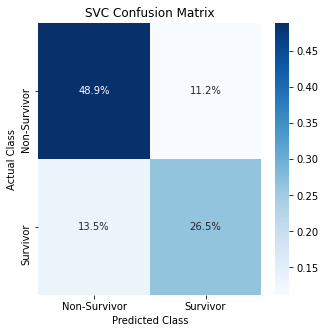

In [39]:
cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch random forest model

In [40]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [.2, .4, .6, .8, 1],
              'max_samples': [.03, .035, .04, .045, .05],
              'min_impurity_decrease': [.012, .013, .014, .015, .016]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
RandomForestClassifier(max_features=0.4, max_samples=0.045,
                       min_impurity_decrease=0.012, n_jobs=-1,
                       random_state=712)
0.8143867130512848


Fit and evaluate top performing random forest model

In [41]:
rf = RandomForestClassifier(criterion='gini', max_features=0.4, max_samples=0.045,
                       min_impurity_decrease=0.012, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.7030878859857482
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.7074829931972789
Test Accuracy Score: 0.8071748878923767


Create Random Forest confusion matrix

[Text(0, 0.5, 'Non-Survivor'), Text(0, 1.5, 'Survivor')]

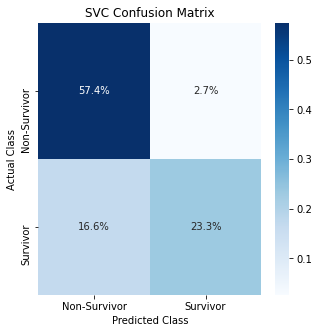

In [49]:
cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
matrix = sns.heatmap(cm/np.sum(cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
matrix.set_title('SVC Confusion Matrix')
matrix.set_xlabel('Predicted Class')
matrix.set_xticklabels(['Non-Survivor', 'Survivor'])
matrix.set_ylabel('Actual Class')
matrix.set_yticklabels(['Non-Survivor', 'Survivor'])

Gridsearch XGBoost model

In [ ]:
xgb_gs_dict = {'colsample_bynode': [.2, .4, .6, .8, 1],
               'gamma': [.1, .3, 1, 3, .10],
               'learnin_rate': [.1, .3, 1, 3, .10]
               'subsample': [.1, .2, .4, .7, 1],
               'reg_lambda': [.1, .3, 1, 3, .10]}
xgb_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
xgb_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
xgb_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fit and evaluate voting classifier

In [48]:
vc = VotingClassifier([('svc', svc), ('ab', ab)], voting='soft', weights=[1, ])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))

Voting Classifier: 
Train f1 Score:  0.7204968944099378
Train Accuracy Score: 0.7979041916167665
Test f1 Score:  0.6820809248554913
Test Accuracy Score: 0.7533632286995515


<ipython-input-44-e231bc2e62a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df['Fare'] = joint_df['Fare'].round(-1)


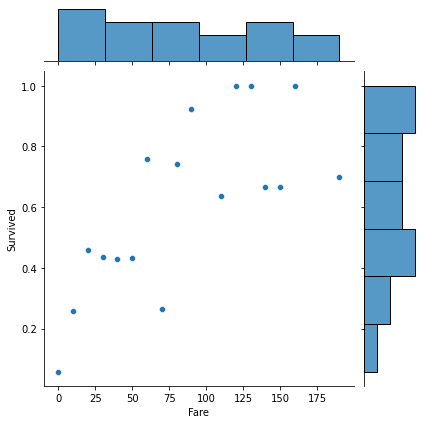

In [44]:
joint_df = df[['Fare', 'Survived']]
joint_df['Fare'] = joint_df['Fare'].round(-1)
joint_df = joint_df.groupby('Fare').mean()[['Survived']].reset_index()
sns.jointplot(x='Fare', y='Survived', data=joint_df)

In [31]:
df.columns

Index(['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_1.0',
       'SibSp_2.0', 'SibSp_3.0', 'SibSp_4.0', 'Parch_1.0', 'Parch_2.0',
       'Parch_3.0', 'Survived'],
      dtype='object')

In [33]:
df.groupby('Embarked_C').mean()['Survived']

Embarked_C
0.0    0.342580
0.4    1.000000
1.0    0.553571
Name: Survived, dtype: float64

In [34]:
df.groupby('Embarked_Q').mean()['Survived']

Embarked_Q
0.0    0.383292
1.0    0.389610
Name: Survived, dtype: float64

In [35]:
df.groupby('Embarked_S').mean()['Survived']

Embarked_S
0.0    0.502041
0.6    1.000000
1.0    0.336957
Name: Survived, dtype: float64

In [235]:
pd.DataFrame(lr.coef_, columns=x.columns).T.reset_index().sort_values(by=0)

,index,0
4,Sex_male,-0.863842
3,Pclass_3,-0.315829
0,Age,-0.258082
11,SibSp_5.0,-0.221416
9,SibSp_3.0,-0.116436
10,SibSp_4.0,-0.115687
6,Embarked_S,-0.053866
14,Parch_3.0,-0.034785
8,SibSp_2.0,-0.012473
13,Parch_2.0,0.044139


In [197]:
df.corr()['Fare']

Age           0.100958
Fare          1.000000
Pclass_1      0.682347
Pclass_3     -0.483153
Sex_male     -0.225493
Embarked_C    0.276246
Embarked_S   -0.155633
SibSp_1.0     0.194928
SibSp_2.0     0.078200
SibSp_3.0     0.090448
SibSp_4.0     0.006045
SibSp_5.0     0.091760
Parch_1.0     0.129073
Parch_2.0     0.243309
Parch_3.0     0.035550
Survived      0.288140
Name: Fare, dtype: float64

In [240]:
df.groupby('Pclass').mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [246]:
df[df['Sex']=='male'].groupby('Pclass').mean()['Survived']

Pclass
1    0.368852
2    0.157407
3    0.135447
Name: Survived, dtype: float64

In [247]:
df[df['Sex']=='female'].groupby('Pclass').mean()['Survived']

Pclass
1    0.968085
2    0.921053
3    0.500000
Name: Survived, dtype: float64

In [253]:
df[df['Pclass']==1].groupby('Sex').count()['Survived']

Sex
female     94
male      122
Name: Survived, dtype: int64

In [254]:
df[df['Pclass']==2].groupby('Sex').count()['Survived']

Sex
female     76
male      108
Name: Survived, dtype: int64

In [255]:
df[df['Pclass']==3].groupby('Sex').count()['Survived']

Sex
female    144
male      347
Name: Survived, dtype: int64

In [267]:
df[(df['Sex']=='female')&(df['Pclass']==3)].groupby('Parch').mean()['Survived']

Parch
0    0.588235
1    0.480000
2    0.320000
3    0.500000
4    0.000000
5    0.250000
6    0.000000
Name: Survived, dtype: float64

In [266]:
df[(df['Sex']=='male')&(df['Pclass']==1)].groupby('Parch').mean()['Survived']

Parch
0    0.363636
1    0.285714
2    0.625000
4    0.000000
Name: Survived, dtype: float64

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
